# Analysis with the `Race` column

In [1]:
import pandas as pd

# Aequitas

Total number of rows in raw data: 7214
Total number of rows after filtering: 6172
Correlation between length of stay and decile score: 0.2075
Demographic Breakdown:
Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%
Two-year recidivism rate: 45.51%


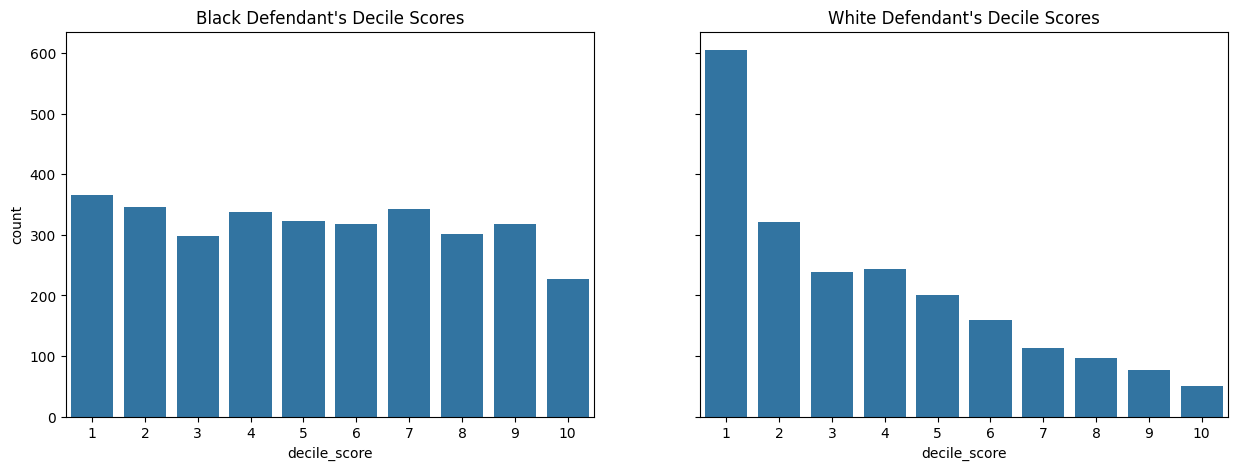

Data columns after get_dummies: ['age', 'score_text', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'length_of_stay', 'c_charge_degree_F', 'c_charge_degree_M', 'age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other', 'sex_Female', 'sex_Male', 'score_factor']
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      3421
           1       0.74      0.69      0.71      2751

    accuracy                           0.75      6172
   macro avg       0.75      0.75      0.75      6172
weighted avg       0.75      0.75      0.75      6172


Odds Ratios for significant factors:
Black defendants are 1.6230018900385719 times more likely to receive a higher score.
Women are 0.8169322281047161 times less likely to receive a higher score.
People under 25 are 3.

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

raw_data = pd.read_csv("./compas-scores-two-years.csv")
print(f"Total number of rows in raw data: {raw_data.shape[0]}")

df = raw_data[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 
               'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 
               'two_year_recid', 'c_jail_in', 'c_jail_out']]

df = df[(df['days_b_screening_arrest'] <= 30) &
        (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) &
        (df['c_charge_degree'] != "O") &
        (df['score_text'] != 'N/A')]

print(f"Total number of rows after filtering: {df.shape[0]}")

df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).dt.days
correlation = df['length_of_stay'].corr(df['decile_score'])
print(f"Correlation between length of stay and decile score: {correlation:.4f}")

age_cat_summary = df['age_cat'].value_counts()
race_summary = df['race'].value_counts()
sex_summary = df['sex'].value_counts()

print("Demographic Breakdown:")
print(f"Black defendants: {race_summary.get('African-American', 0) / len(df) * 100:.2f}%")
print(f"White defendants: {race_summary.get('Caucasian', 0) / len(df) * 100:.2f}%")
print(f"Hispanic defendants: {race_summary.get('Hispanic', 0) / len(df) * 100:.2f}%")
print(f"Asian defendants: {race_summary.get('Asian', 0) / len(df) * 100:.2f}%")
print(f"Native American defendants: {race_summary.get('Native American', 0) / len(df) * 100:.2f}%")

two_year_recid_count = df[df['two_year_recid'] == 1].shape[0]
two_year_recid_rate = (two_year_recid_count / len(df)) * 100
print(f"Two-year recidivism rate: {two_year_recid_rate:.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.countplot(x="decile_score", data=df[df['race'] == "African-American"], ax=axes[0])
axes[0].set_title("Black Defendant's Decile Scores")
sns.countplot(x="decile_score", data=df[df['race'] == "Caucasian"], ax=axes[1])
axes[1].set_title("White Defendant's Decile Scores")
plt.show()

df = pd.get_dummies(df, columns=['c_charge_degree', 'age_cat', 'race', 'sex'])



df['score_factor'] = np.where(df['score_text'] != "Low", 1, 0) 

print("Data columns after get_dummies:", df.columns.tolist())

X_columns = [
    'sex_Male', 'age_cat_Greater than 45', 'age_cat_Less than 25', 
    'race_African-American', 'race_Asian', 'race_Hispanic', 'race_Native American', 
    'race_Other', 'priors_count', 'two_year_recid'
]

missing_columns = [col for col in X_columns if col not in df.columns]
if missing_columns:
    print("Warning: The following expected columns are missing:", missing_columns)
else:
    X = df[X_columns]
    y = df['score_factor']

    scaler = StandardScaler()
    X[['priors_count']] = scaler.fit_transform(X[['priors_count']])

    log_reg = LogisticRegression()
    log_reg.fit(X, y)

    y_pred = log_reg.predict(X)
    print(classification_report(y, y_pred))

    odds_ratios = np.exp(log_reg.coef_).flatten()
    odds_ratios_dict = {feature: odds_ratio for feature, odds_ratio in zip(X.columns, odds_ratios)}
    print("\nOdds Ratios for significant factors:")
    print(f"Black defendants are {odds_ratios_dict.get('race_African-American', 'N/A')} times more likely to receive a higher score.")
    print(f"Women are {odds_ratios_dict.get('sex_Male', 'N/A')} times less likely to receive a higher score.")
    print(f"People under 25 are {odds_ratios_dict.get('age_cat_Less than 25', 'N/A')} times as likely to receive a higher score as middle-aged defendants.")


# Exploration

This cell selects the specific columns needed for analysis, focusing on features related to demographic information, COMPAS scores, and recidivism. (we can ignore name columns)

In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

raw_data = pd.read_csv("./compas-scores-two-years.csv")
print(f"Total number of rows in raw data: {raw_data.shape[0]}")

df = raw_data[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 
               'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 
               'two_year_recid', 'c_jail_in', 'c_jail_out']]


Total number of rows in raw data: 7214


Filtering the dataset to exclude cases with invalid information.

In [4]:
df = df[(df['days_b_screening_arrest'] <= 30) &
        (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) &
        (df['c_charge_degree'] != "O") &
        (df['score_text'] != 'N/A')]

print(f"Total number of rows after filtering: {df.shape[0]}")


Total number of rows after filtering: 6172


This cell calculates each defendant’s jail stay length by converting jail entry and exit dates into a datetime format. It then computes the correlation between **length_of_stay** and the **decile_score**.

In [5]:
# Calculate the length of stay and correlate it with the decile score
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).dt.days
correlation = df['length_of_stay'].corr(df['decile_score'])
print(f"Correlation between length of stay and decile score: {correlation:.4f}")


Correlation between length of stay and decile score: 0.2075


This cell provides a breakdown of demographic information for race, age categories, and sex, printing the percentages of each racial group.

In [6]:
# Summarize demographic data for age, race, and sex
age_cat_summary = df['age_cat'].value_counts()
race_summary = df['race'].value_counts()
sex_summary = df['sex'].value_counts()

# Display demographic breakdown
print("Demographic Breakdown:")
print(f"Black defendants: {race_summary.get('African-American', 0) / len(df) * 100:.2f}%")
print(f"White defendants: {race_summary.get('Caucasian', 0) / len(df) * 100:.2f}%")
print(f"Hispanic defendants: {race_summary.get('Hispanic', 0) / len(df) * 100:.2f}%")
print(f"Asian defendants: {race_summary.get('Asian', 0) / len(df) * 100:.2f}%")
print(f"Native American defendants: {race_summary.get('Native American', 0) / len(df) * 100:.2f}%")


Demographic Breakdown:
Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


This cell calculates the percentage of individuals who recidivated within two years, giving an overview of the recidivism rate in the dataset.

In [7]:
# Calculate the two-year recidivism rate
two_year_recid_count = df[df['two_year_recid'] == 1].shape[0]
two_year_recid_rate = (two_year_recid_count / len(df)) * 100
print(f"Two-year recidivism rate: {two_year_recid_rate:.2f}%")


Two-year recidivism rate: 45.51%


This cell visualizes the distribution of **decile_score** values for African-American and Caucasian defendants, providing insight into score differences across racial groups.

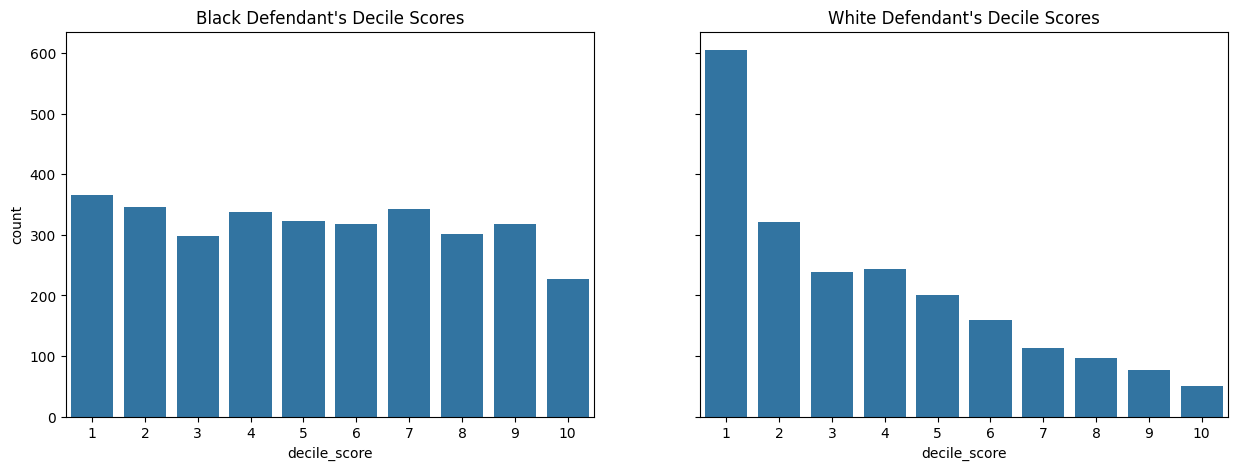

In [8]:
# Plot distribution of Decile Scores by Race for African-American and Caucasian defendants
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.countplot(x="decile_score", data=df[df['race'] == "African-American"], ax=axes[0])
axes[0].set_title("Black Defendant's Decile Scores")
sns.countplot(x="decile_score", data=df[df['race'] == "Caucasian"], ax=axes[1])
axes[1].set_title("White Defendant's Decile Scores")
plt.show()


This cell creates dummy variables for categorical columns, ensuring that all racial categories are retained by setting **drop_first=False** specifically for **race**.

In [9]:
# Convert categorical variables to dummy variables, retaining all race categories
df = pd.get_dummies(df, columns=['c_charge_degree', 'age_cat', 'race', 'sex'], drop_first=False)


This cell creates a binary **score_factor** column where 1 indicates a high or medium score, and 0 indicates a low score. It also displays the column names to confirm dummy variable generation.

In [10]:
# Create a binary target variable for the logistic regression model
df['score_factor'] = np.where(df['score_text'] != "Low", 1, 0)  # HighScore=1, LowScore=0

# Display the final list of columns after dummy variable encoding
print("Data columns after get_dummies:", df.columns.tolist())


Data columns after get_dummies: ['age', 'score_text', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'length_of_stay', 'c_charge_degree_F', 'c_charge_degree_M', 'age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other', 'sex_Female', 'sex_Male', 'score_factor']


This cell selects feature columns based on expected dummy variables. It checks if any expected columns are missing, which helps avoid errors if certain categories were not created.

In [11]:
# Define feature columns for logistic regression based on actual dummy variable names
X_columns = [
    'sex_Male', 'age_cat_Greater than 45', 'age_cat_Less than 25', 
    'race_African-American', 'race_Asian', 'race_Hispanic', 'race_Native American', 
    'race_Other', 'priors_count', 'two_year_recid'
]

# Check for missing expected columns
missing_columns = [col for col in X_columns if col not in df.columns]
if missing_columns:
    print("Warning: The following expected columns are missing:", missing_columns)
else:
    X = df[X_columns]
    y = df['score_factor']


This cell standardizes **priors_count** to improve logistic regression model performance, ensuring it’s on a comparable scale with other features.

In [12]:
# Standardize the 'priors_count' feature for better logistic regression performance
scaler = StandardScaler()
X[['priors_count']] = scaler.fit_transform(X[['priors_count']])


This cell trains the logistic regression model on the dataset and prints a classification report to evaluate performance on the binary classification task.

In [13]:
# Fit Logistic Regression Model and print classification report
log_reg = LogisticRegression()
log_reg.fit(X, y)
y_pred = log_reg.predict(X)
print(classification_report(y, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.81      0.78      3421
           1       0.74      0.69      0.71      2751

    accuracy                           0.75      6172
   macro avg       0.75      0.75      0.75      6172
weighted avg       0.75      0.75      0.75      6172



This cell calculates and displays odds ratios for each feature in the logistic regression model, offering insight into how different factors (e.g., race, age) affect the likelihood of receiving a high COMPAS score.

In [14]:
# Calculate and display odds ratios for model coefficients
odds_ratios = np.exp(log_reg.coef_).flatten()
odds_ratios_dict = {feature: odds_ratio for feature, odds_ratio in zip(X.columns, odds_ratios)}
print("\nOdds Ratios for significant factors:")
print(f"Black defendants are {odds_ratios_dict.get('race_African-American', 'N/A')} times more likely to receive a higher score.")
print(f"Women are {odds_ratios_dict.get('sex_Male', 'N/A')} times less likely to receive a higher score.")
print(f"People under 25 are {odds_ratios_dict.get('age_cat_Less than 25', 'N/A')} times as likely to receive a higher score as middle-aged defendants.")



Odds Ratios for significant factors:
Black defendants are 1.6230018900385719 times more likely to receive a higher score.
Women are 0.8169322281047161 times less likely to receive a higher score.
People under 25 are 3.78169054478933 times as likely to receive a higher score as middle-aged defendants.


# Analysis without the `race` column

## Data processing

In [15]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Ignore warnings
warnings.filterwarnings('ignore')

# Load and filter the dataset
raw_data = pd.read_csv("./compas-scores-two-years.csv")
df = raw_data[['age', 'c_charge_degree', 'age_cat', 'score_text', 'sex', 
               'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 
               'two_year_recid', 'c_jail_in', 'c_jail_out']]

# Filter the data based on the specified conditions
df = df[(df['days_b_screening_arrest'] <= 30) &
        (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) &
        (df['c_charge_degree'] != "O") &
        (df['score_text'] != 'N/A')]

# Calculate length of stay in jail
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['length_of_stay'] = (df['c_jail_out'] - df['c_jail_in']).dt.days


## Feature Engineering withour the `race` column

In [16]:
# Create dummy variables for categorical columns except for 'race'
df = pd.get_dummies(df, columns=['c_charge_degree', 'age_cat', 'sex'], drop_first=True)

# Create a binary target variable for the logistic regression model
df['score_factor'] = np.where(df['score_text'] != "Low", 1, 0)  # HighScore=1, LowScore=0


## Define Features and Fit Logistic Regression Model

In [17]:
X_columns = ['sex_Male', 'age_cat_Greater than 45', 'age_cat_Less than 25', 
             'priors_count', 'two_year_recid', 'length_of_stay']
X = df[X_columns]
y = df['score_factor']

scaler = StandardScaler()
X[['priors_count', 'length_of_stay']] = scaler.fit_transform(X[['priors_count', 'length_of_stay']])

log_reg = LogisticRegression()
log_reg.fit(X, y)

y_pred = log_reg.predict(X)
print(classification_report(y, y_pred))


              precision    recall  f1-score   support

           0       0.76      0.81      0.79      3421
           1       0.74      0.69      0.71      2751

    accuracy                           0.76      6172
   macro avg       0.75      0.75      0.75      6172
weighted avg       0.75      0.76      0.75      6172



## Analyze Race Distribution by Risk Category


Race distribution by predicted risk score:
race             African-American  Asian  Caucasian  Hispanic  \
predicted_score                                                 
0                            1491     24       1507       358   
1                            1684      7        596       151   

race             Native American  Other  
predicted_score                          
0                              5    245  
1                              6     98  


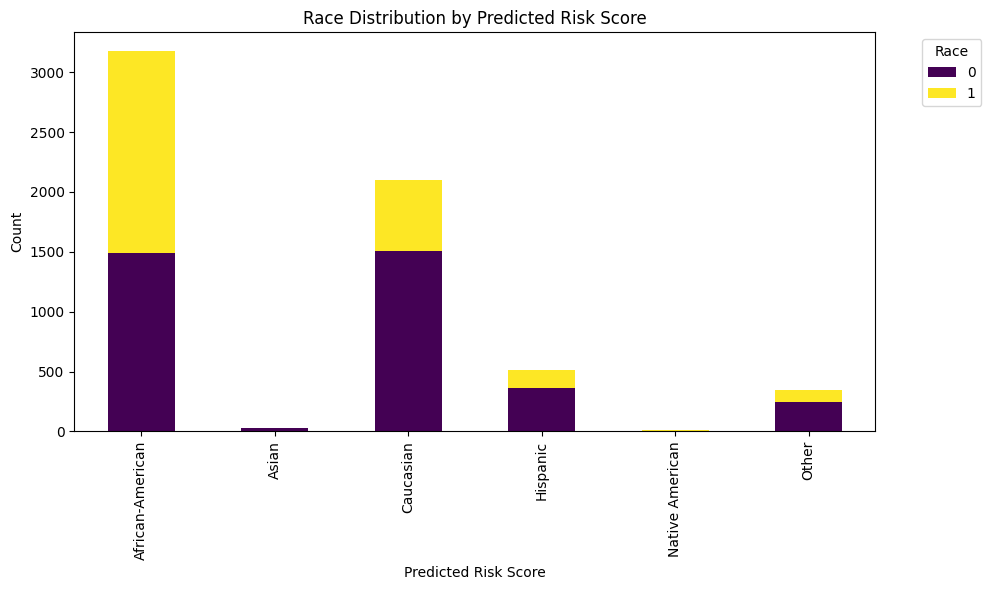

In [18]:
# Add the predicted scores to the filtered DataFrame (df) with matching index
df['predicted_score'] = y_pred

# Extract the 'race' column for only the rows in 'df' (using the same index)
df['race'] = raw_data.loc[df.index, 'race']

# Now, we proceed to analyze the race distribution within each predicted score
race_distribution = df.groupby(['predicted_score', 'race']).size().unstack().fillna(0)

# Print the race distribution by predicted risk score to verify
print("\nRace distribution by predicted risk score:")
print(race_distribution)

# Plotting the race distribution as a stacked bar chart
race_distribution.T.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Adding labels and title for clarity
plt.title("Race Distribution by Predicted Risk Score")
plt.xlabel("Predicted Risk Score")
plt.ylabel("Count")
plt.legend(title="Race", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Aequitas

## Colunas a usar

- sex
- age_cat
- race
- juv_fail_count
- decile_score
- juv_misd_count
- juv_other_count
- days_b_screening_arrest
- c_charge_degree
- is_recid
- r_charge_degree
- is_violent_recid
- vr_charge_degree
- score_text
- v_score_text
- two_year_recid

In [19]:
from aequitas import Audit
import aequitas.plot as ap

In [71]:
original_df = pd.read_csv("compas-scores-two-years.csv")

# DROPING days_b_screening_arrest, TO BE DISCUSSED

columns_to_select = [
    "sex", "age_cat", "race", "juv_fel_count", "decile_score", "juv_misd_count", "juv_other_count", 
    "c_charge_degree", "is_recid", "r_charge_degree", "is_violent_recid", 
    "vr_charge_degree", "score_text", "v_score_text", "two_year_recid"
]

new_df = original_df[columns_to_select]

# add df['score_factor'] and df['predicted_score'] to new_df
new_df['score_factor'] = df['score_factor']
new_df['predicted_score'] = df['predicted_score'] 



In [72]:
# join is_recid and is_violent_recid to create a new column 'recidivism'
new_df.insert(5, 'recidivism', new_df['is_recid'] + new_df['is_violent_recid'])

# convert to string according to map 0 -> no, 1 -> normal, 2 -> violent
new_df['recidivism'] = new_df['recidivism'].map({0: 'no', 1: 'normal', 2: 'violent'})

# drop is_recid and is_violent_recid
new_df = new_df.drop(columns=['is_recid', 'is_violent_recid'])

In [73]:
# drop rows with missing values
new_df = new_df.dropna()

In [74]:
# convert columns to categorical
for column in new_df.columns:
    new_df[column] = new_df[column].astype('object')
    
# convert target columns to numerical
new_df['predicted_score'] = new_df[column].astype('int')
new_df['score_factor'] = new_df[column].astype('int')

In [75]:
audit = Audit(new_df, label_column="predicted_score", score_column="score_factor", sensitive_attribute_column=["sex", "age_cat", "race", "recidivism", "c_charge_degree", "decile_score", "juv_fel_count", "juv_misd_count", "juv_other_count", "r_charge_degree", "vr_charge_degree", "score_text", "v_score_text", "two_year_recid"])
audit.audit()